In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
time = 0.5 #(s)
nb_steps = 5000
nb_neurons = 10
h = time/nb_steps #0.001
ext_poisson_rate = 3. #Poisson rate (Hz)
nb_neuron_ext = 800
tau_AMPA = 0.002 #
V_L = -0.07 #rest potential
V_E = 0.0 #reversal potential
V_I = -0.07
V_thr = -0.05
g_AMPA_ext = 2.08e-9 #synaptic excitatory conductance
g_AMPA_rec = 104.0e-9/nb_neurons
g_GABA = 1.
g_m = 25.0e-9 #membrane conductance
C_m = 0.5e-9 #membrane capacitance
tau_rp = 0.002
fraction = 0.15
w = 1.0
w_plus = 1.5
w_minus = 1 - fraction * (w_plus - 1) / (1 - fraction)

In [3]:
def sj_dot(sj, poisson):
    return -sj/tau_AMPA #+ poisson

In [4]:
class Neuron:
    instances = []
    def __init__(self):
        Neuron.instances.append(self)
        self.V = V_L
        self.refractory_time = False
        self.start_refractory_time = -100.
        self.s_AMPA = 0.
        self.send_pike = False
                
    def update_AMPA(self, h):
        if self.send_pike == True:
            self.s_AMPA = 1.0
            self.send_pike = False
        else:
            self.s_AMPA += - (self.s_AMPA / tau_AMPA * h)


class NeuronE(Neuron):
    instances = []
    def __init__(self):
        Neuron.__init__(self)
        NeuronE.instances.append(self)
    
    def update_V(self, h, ext_amp, rec_amp_A, rec_amp_B, rec_amp_E, current_t):
        if np.abs(current_t - self.start_refractory_time) < tau_rp:
            self.V = V_L
        else:
            rec_amp = rec_amp_A + rec_amp_B + rec_amp_E
            I_AMPA_rec = g_AMPA_rec * (self.V - V_E) * rec_amp
            I_AMPA_ext = g_AMPA_ext * (self.V - V_E) * ext_amp
            I_syn = I_AMPA_ext + I_AMPA_rec
            self.V += (- g_m * (self.V - V_L) - I_syn) * h / C_m
            if self.V > V_thr:
                self.start_refractory_time = current_t
                self.send_pike = True

                
class NeuronA(Neuron):
    instances = []
    def __init__(self):
        Neuron.__init__(self)
        NeuronA.instances.append(self)
    
    def update_V(self, h, ext_amp, rec_amp_A, rec_amp_B, rec_amp_E, current_t):
        if np.abs(current_t - self.start_refractory_time) < tau_rp:
            self.V = V_L
        else:
            rec_amp = rec_amp_A*w_plus + rec_amp_B*w_minus + rec_amp_E
            I_AMPA_rec = g_AMPA_rec * (self.V - V_E) * rec_amp
            I_AMPA_ext = g_AMPA_ext * (self.V - V_E) * ext_amp
            I_syn = I_AMPA_ext + I_AMPA_rec
            self.V += (- g_m * (self.V - V_L) - I_syn) * h / C_m
            if self.V > V_thr:
                self.start_refractory_time = current_t
                self.send_pike = True
                
                
class NeuronB(Neuron):
    instances = []
    def __init__(self):
        Neuron.__init__(self)
        NeuronB.instances.append(self)
    
    def update_V(self, h, ext_amp, rec_amp_A, rec_amp_B, rec_amp_E, current_t):
        if np.abs(current_t - self.start_refractory_time) < tau_rp:
            self.V = V_L
        else:
            rec_amp = rec_amp_A*w_minus + rec_amp_B*w_plus + rec_amp_E
            I_AMPA_rec = g_AMPA_rec * (self.V - V_E) * rec_amp
            I_AMPA_ext = g_AMPA_ext * (self.V - V_E) * ext_amp
            I_syn = I_AMPA_ext + I_AMPA_rec
            self.V += (- g_m * (self.V - V_L) - I_syn) * h / C_m
            if self.V > V_thr:
                self.start_refractory_time = current_t
                self.send_pike = True
                
class NeuronI():
    instances = []
    def __init__(self):
        NeuronI.instances.append(self)
        

In [5]:
for i in range(int(nb_neurons*(1-2*fraction))):
    NeuronE()
for i in range(int(nb_neurons*fraction)):
    NeuronA()
    NeuronB()

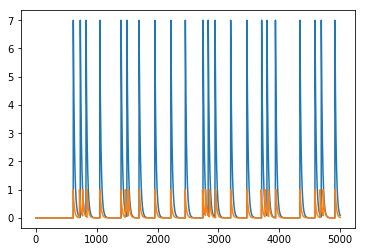

In [6]:
V_test = []
V_test1 = []
sj_list = np.zeros(nb_neuron_ext)
sj_dot_list = np.zeros(nb_neuron_ext)

for t in range(int(time/h)):
    ext_amp = np.random.poisson(ext_poisson_rate*nb_neuron_ext*tau_AMPA,1)
    stimuli = np.random.poisson((ext_poisson_rate*nb_neuron_ext + 50)*tau_AMPA,1)
    rec_amp_A = 0.
    rec_amp_B = 0.
    rec_amp_E = 0.
    for n in NeuronE.instances:
        n.update_AMPA(h)
        rec_amp_E += n.s_AMPA
    for n in NeuronA.instances:
        n.update_AMPA(h)
        rec_amp_A += n.s_AMPA
    for n in NeuronB.instances:
        n.update_AMPA(h)
        rec_amp_B += n.s_AMPA
        
    for n in NeuronE.instances:
        n.update_V(h, ext_amp, rec_amp_A, rec_amp_B, rec_amp_E, t*h/time)
    for n in NeuronA.instances + NeuronB.instances:
        n.update_V(h, stimuli, rec_amp_A, rec_amp_B, rec_amp_E, t*h/time)
    #V_test.append(Neuron.instances[0].V*100)
    V_test.append(rec_amp_E)
    V_test1.append(rec_amp_B)
plt.plot(V_test)
plt.plot(V_test1)

(array([0.00027317, 0.0017301 , 0.00537242, 0.01793843, 0.04689488,
        0.09952642, 0.14842458, 0.18421038, 0.16454185, 0.12311045,
        0.07248219, 0.03205242, 0.01038061, 0.00300491, 0.00063741]),
 array([-3.71378563, -2.61558477, -1.5173839 , -0.41918303,  0.67901784,
         1.77721871,  2.87541957,  3.97362044,  5.07182131,  6.17002218,
         7.26822305,  8.36642391,  9.46462478, 10.56282565, 11.66102652,
        12.75922738]),
 <a list of 15 Patch objects>)

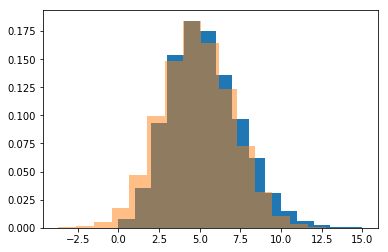

In [7]:
plt.hist(np.random.poisson(4.8, 10000),15,density=True)
plt.hist(np.random.normal(4.8,np.sqrt(4.8),10000), 15, density = True, alpha=0.5)